In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.discrete.discrete_model as sm
import statsmodels.stats.multitest as mt
from sklearn.preprocessing import Imputer
import sklearn.metrics as sklm
import warnings 
warnings.filterwarnings("ignore") # Ignore annoying warnings
# from sklearn.model_selection import cross_val_score

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]
    


$$P(x) = \frac{1}{1 + e^{-(\beta_0 + \sum_{i}\beta_i x_i)}} $$

In [3]:
# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
cdf = imp.transform(cdf)
cdf = pd.DataFrame(cdf, columns=colNames)

# Add an intercept
cdf['intercept'] = 1.0

In [4]:
from sklearn.base import BaseEstimator, ClassifierMixin
class stepwiseLogitRegression(BaseEstimator):
    
    def __init__(self):
        self.model = []    
        self.useCols = []
    
    def score(self, X, y):
        predRes = self.model.predict(X[self.useCols])
        rocAUC = sklm.roc_auc_score(y,predRes)
        return rocAUC
    
    def predict(self, X):
        predRes = self.model.predict(X[self.useCols])
        return predRes

    def fit(self, X, y):
    
        # Make a list of columns to include in our fit
        inclCol = pd.Series([False for colName in X.columns], dtype=bool, index=X.columns)
        inclCol['intercept'] = True
    
        # Loop while we're sitll adding or subtracting columns
        anyChanges = True
        while (anyChanges):
            anyChanges, inclCol, smresult = self.tryCols( X, y, inclCol)
        print(smresult.summary())
        
        self.model = smresult
        self.useCols = inclCol[inclCol==True].index.values.tolist()
        return smresult

    def tryCols(self, X, y, inclCol):

        anyChanges = False

        addThresh  = 0.05
        dumpThresh = 0.15

        baseCols = inclCol[inclCol==True].index.values.tolist()
        tryCols =  inclCol[inclCol==False].index.values.tolist()

        # Try to fit all the variables we should try out in the model
        fitResultList = []
        for colName in tryCols:
            modelCols = baseCols + [colName]

            try: 
                logit = sm.Logit(y, X[modelCols])
                smresult = logit.fit(disp=False)
                fitResultList = fitResultList + [(smresult.pvalues[colName], colName)]
            except:
                a = 1
                # print('*** ' + colName + ': Exception ***')

        # Correct the p-values for multiple comparisons
        pValues = [fitItem[0] for fitItem in fitResultList]
        reject, pValues, alphacSidak, alphacBonf = mt.multipletests(pValues, alpha=0.05, method='holm')
        corrResultList = [(pValues[index], item[1]) for index, item in enumerate(fitResultList)]
        fitResultList = corrResultList

        # If the most significant variable is below threshold, add it to the list
        fitResultList.sort()
        bestFit = fitResultList[0]
        if bestFit[0] < addThresh:
            print('\t Adding: %s p = %.5f' % (bestFit[1], bestFit[0]))
            inclCol[bestFit[1]] = True
            anyChanges = True
        else:
            print('\t Not adding term. Best variable: %s p = %.5f' % (bestFit[1], bestFit[0]))

        # Ok, now re-fit the model with the existing terms
        modelCols = inclCol[inclCol==True].index.values.tolist()
        logit = sm.Logit(y, X[modelCols])
        smresult = logit.fit(disp=False)  

        # Correct model p-values for multiple comparisons before consideration
        # of dropping the largest.
        pValues = smresult.pvalues
        reject, pValues, alphacSidak, alphacBonf = mt.multipletests(pValues, alpha=0.05, method='holm')
        maxP = pValues.max()
        colToDump = pValues.argmax()
        if  maxP > dumpThresh and colToDump != 'intercept':
            inclCol[colToDump] = False
            anyChanges = True
            print('\t Removing term: %s p = %.5f' % (colToDump, maxP))

        return anyChanges, inclCol, smresult

In [5]:
# Might need to implement some more parts of this estimator...
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(stepwiseLogitRegression)

In [6]:
swl = stepwiseLogitRegression()
smresult = swl.fit(cdf, y)

	 Adding: NWNDINFD-0 p = 0.00000
	 Adding: DIABETES-NO p = 0.00000
	 Adding: PRALBUM p = 0.00000
	 Adding: AGE p = 0.00000
	 Adding: PRALKPH p = 0.00001
	 Adding: DIALYSIS-Yes p = 0.00202
	 Not adding term. Best variable: FNSTATUS2-Partially Dependent p = 0.15184
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                14996
Model:                          Logit   Df Residuals:                    14989
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Dec 2016   Pseudo R-squ.:                  0.1146
Time:                        14:31:19   Log-Likelihood:                -1739.9
converged:                       True   LL-Null:                       -1965.1
                                        LLR p-value:                 4.055e-94
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------

In [7]:
swl.score(cdf, y)

0.72647529046308901

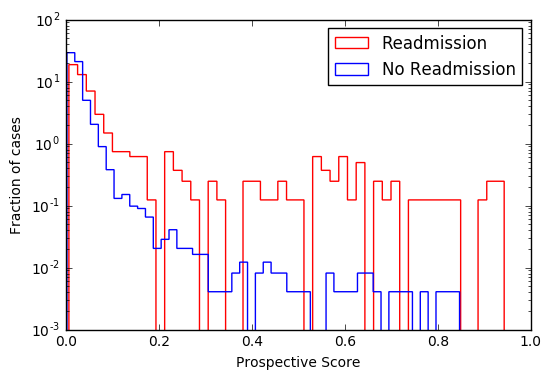

In [8]:
predRes = swl.predict(cdf)

plt.clf
plt.hist(predRes[(y == True)],bins=50,histtype='step',color='r',normed=True,\
        label='Readmission')
plt.hist(predRes[(y == False)],bins=50,histtype='step',color='b',normed=True,\
        label='No Readmission')
plt.yscale('log', nonposy='clip')
plt.legend(loc='upper right')
plt.xlabel('Prospective Score')
plt.ylabel('Fraction of cases')
plt.show()

ROC AUC = 0.726 


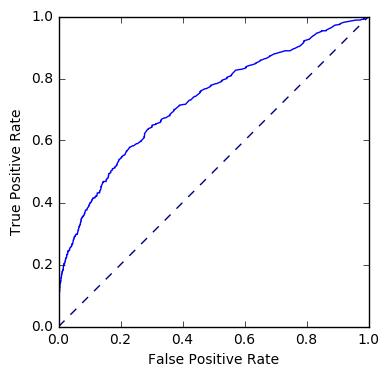

In [9]:

rocAUC = sklm.roc_auc_score(y,predRes)
print('ROC AUC = %.3f ' % rocAUC)
fpr, tpr, _ = sklm.roc_curve(y, predRes)
plt.figure()
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [10]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(swl, cdf, y, cv=10)

	 Adding: NWNDINFD-0 p = 0.00000
	 Adding: PRALBUM p = 0.00000
	 Adding: AGE p = 0.00000
	 Adding: DIABETES-INSULIN p = 0.00000
	 Adding: PRALKPH p = 0.00199
	 Adding: DIALYSIS-Yes p = 0.03831
	 Not adding term. Best variable: DYSPNEA-No p = 0.21706
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                13496
Model:                          Logit   Df Residuals:                    13489
Method:                           MLE   Df Model:                            6
Date:                Mon, 19 Dec 2016   Pseudo R-squ.:                  0.1101
Time:                        14:31:28   Log-Likelihood:                -1493.0
converged:                       True   LL-Null:                       -1677.8
                                        LLR p-value:                 9.658e-77
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------

In [11]:
scores

array([ 0.7373834 ,  0.73043634,  0.75072377,  0.64987052,  0.70041064,
        0.71100171,  0.74044256,  0.74676148,  0.68156045,  0.71633657])